# HW3 Class Competition

Authors: Duke Li, Annie Liu, Sergey Ovsianyk, Bella Wang, Binbin Xia

# Who survived the sinking of the Titanic?

The goal of this HW is to predict who survived the Titanic sinking in 1912.

## Data set description

<ul>
<li><b>Survived</b>: binary attribute that indicates whether the passenger survived. This is the dependent variable that we will attempt to explain
<li><b>Pclass</b>: Ticket class (1 = 1st class, 2 = 2nd class, 3 = 3rd class)
<li><b>Age</b>: Passenger age
<li><b>SibSp</b>: The amout of the passenger's siblings/spouses aboard the Titanic
<li><b>Parch</b>: The amout of the passenger's parents/children aboard the Titanic
<li><b>Fare</b>: The ticket fare
<li><b>Male</b>: binary attibute that indicates the gender (1=Male, 0=Female)
<li><b>Embarked_C</b>: binary attibute that indicates whether the passenger embarked in Cherbourg
<li><b>Embarked_Q</b>: binary attibute that indicates whether the passenger embarked in Queenstown
<li><b>Embarked_S</b>: binary attibute that indicates whether the passenger embarked in Southampton
</ul>

## Instruction

Cleaning the data set if necessary. 

Use everything you know to find a machine learning model to achieve the highest possible AUC score. Two testing sets have been reserved: TestA.csv and TestB.csv. Your homework will be evaluated using these two sets. 75% of the grade will be based on the AUC score on TestA.csv. 25% of the grade will be based on the ranking of the AUC score on TestB.csv among the six groups. To be specific, your grade on TestA.csv will be equal to the final AUC score multiplied by 75, and your grade on TestB.csv will be equal to 5 * (6 - your ranking). You must submit the same model for both sets with clear explanation of your codes. You must include the codes to evaluate your model on TestA.csv and TestB.csv. Failure to do so will result in 20% loss of grades (10% for each test). 

TestB.csv is private, which means you will never see it. The ranking will be revealed only after next Wed deadline. TestA.csv is semi-private. This means that you have at most one chance everyday for me to check your model performance on TestA.csv using your code, and I will let you know the AUC score and post your score on the discussion board. I will save your notebook file in the same folder with the data files. If your code does not work on my computer, you lose the opportunity on the same day. 

In [1]:
import pandas as pd

import numpy as np

import seaborn as sns
from statistics import mode

import sklearn as sk
import sklearn.metrics as met

import scipy.optimize as opt
import warnings

In [36]:
df = pd.read_csv("Titanic_0.csv")

In [3]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q


In [4]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

## Data Wrangling

In [5]:
df.shape

(713, 12)

In [6]:
# checking NAs
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            141
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          549
Embarked         1
dtype: int64

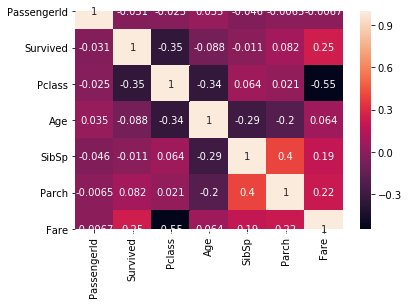

In [7]:
# check what columns are correlated
sns.heatmap(df.corr(), annot = True)

In [8]:
def data_cleaning(df):
    #Cleaning NAs
    #fill Embarked NAs with the mode
    df["Embarked"] = df["Embarked"].fillna(mode(df["Embarked"]))
    #fill Fare NAs with median
    df['Fare'] = df['Fare'].fillna(df['Fare'].median())
    # fill Age NAs with medians by Pclass
    df['Age'] = df.groupby("Pclass")['Age'].transform(lambda x:  x.fillna(x.median()))
    #fill Cabin NAs with 'Unknown'
    df['Cabin'] = df['Cabin'].fillna('Unknown')
    df['Cabin']= df['Cabin'].map(lambda x: x[0])
    
    #Create new column FamilySize
    df['FamilySize'] = df.Parch + df.SibSp + 1
    
    #Dropping columns which are not useful for our prediction
    df = df.drop('Ticket',axis=1)
    df = df.drop('PassengerId',axis=1)
    df = df.drop('Name',axis=1)
    df = df.drop('Parch',axis=1)
    df = df.drop('SibSp',axis=1)
    
    return df

In [9]:
df=data_cleaning(df)
df.head()

,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,FamilySize
0,0,3,male,22.00,7.2500,U,S,2
1,1,1,female,38.00,71.2833,C,C,2
2,1,3,female,26.00,7.9250,U,S,1
3,1,1,female,35.00,53.1000,C,S,2
4,0,3,male,24.25,8.4583,U,Q,1


In [11]:
X = df.drop(['Survived'], axis=1)
y = df.Survived

## Machine Learning Part

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
pd.set_option('display.max_columns', None)

### Random Forest

In [ ]:
#credits : https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html#sphx-glr-download-auto-examples-compose-plot-column-transformer-mixed-types-py

# We create the preprocessing pipelines for both numeric and categorical data.
# to treat numeric and categorical data differently
# listing numeric features
numeric_features = ['Age', 'Fare','FamilySize']
numeric_transformer = Pipeline(steps=[
   ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# listing categorical features
categorical_features = ['Embarked', 'Sex', 'Pclass','Cabin']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])


# Append classifier and polynomial feature generator to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('poly', PolynomialFeatures(5)),
                      ('classifier', RandomForestClassifier(n_estimators=100, max_features='auto', oob_score = True))])

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 0, test_size = 0.2)

In [15]:
# these are the best parameters, based on GridSearchCV result
param_grid = {
    'poly__degree': [2],
    'classifier__criterion':["gini"],
    "classifier__min_samples_leaf" : [5],
    "classifier__min_samples_split" : [35],
    "classifier__n_estimators": [1500]}
    
grid_search = GridSearchCV(clf, param_grid, cv = 6, n_jobs = -1, return_train_score = True, scoring = 'roc_auc')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=6, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                    

In [16]:
df_grid = pd.DataFrame(grid_search.cv_results_)
df_grid['spread_test_train'] = df_grid.mean_train_score - df_grid.mean_test_score

In [17]:
df_grid.sort_values(['spread_test_train', 'mean_test_score', 'mean_train_score'], ascending = [True, False, False], inplace = True)

In [18]:
df_grid[df_grid.rank_test_score == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__criterion,param_classifier__min_samples_leaf,param_classifier__min_samples_split,param_classifier__n_estimators,param_poly__degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,mean_train_score,std_train_score,spread_test_train
0,3.428223,0.026499,0.137249,0.003514,gini,5,35,1500,2,"{'classifier__criterion': 'gini', 'classifier_...",0.884104,0.817224,0.912429,0.831215,0.902538,0.898946,0.874234,0.036718,1,0.920059,0.931382,0.92183,0.927784,0.923002,0.921386,0.924241,0.004011,0.050007


In [19]:
# returning the best model
clf = grid_search.best_estimator_

In [20]:
# training our model, based on the whole dataset
clf.fit(X, y)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                             

### Test Part

#### Test A

In [42]:
df2 = pd.read_csv("TestA.csv")

In [44]:
df2 = data_cleaning(df2)

In [46]:
X2 = df2.drop(['Survived'], axis=1)
y2 = df2.Survived

In [47]:
y2_pred_probab = clf.predict_proba(X2)[:,1]

In [48]:
print('AUC on TestA file is : {}'.format(met.roc_auc_score(y2, y2_pred_probab)))

AUC on TestA file is : 0.9867679066086268


#### Test B

In [49]:
df3 = pd.read_csv("TestB.csv")

FileNotFoundError: [Errno 2] File b'TestB.csv' does not exist: b'TestB.csv'

In [44]:
df2 = data_cleaning(df2)

In [46]:
X2 = df2.drop(['Survived'], axis=1)
y2 = df2.Survived

In [47]:
y2_pred_probab = clf.predict_proba(X2)[:,1]

In [48]:
print('AUC on TestA file is : {}'.format(met.roc_auc_score(y2, y2_pred_probab)))

AUC on TestA file is : 0.9867679066086268
